In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
def parse_method(name):
    name = str(name)
    quant = name.split("_")[0]

    pruning = 0.0
    if "pruned" in name:
        try:
            pruning = float(name.split("_")[-1])
        except ValueError:
            pruning = 0.0

    return pd.Series([quant, pruning])

def parse_project(name):
    quant = name.split("_")[0]
    pruning = 0.0
    if "pruned" in name:
        pruning = float(name.split("_")[-1])
    return pd.Series([quant, pruning])



In [126]:
res = pd.read_csv("results/nmf.csv")
res[["quant", "pruning"]] = res["run_name"].apply(
    lambda x: pd.Series(parse_method(x))
)

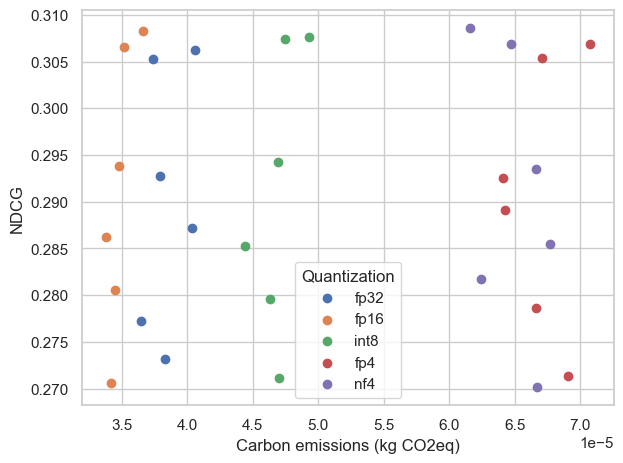

In [127]:
plt.figure()
for q in res["quant"].unique():
    sub = res[res["quant"] == q]
    plt.scatter(sub["emissions"], sub["ndcg10"], label=q)

plt.xlabel("Carbon emissions (kg CO2eq)")
plt.ylabel("NDCG")
plt.legend(title="Quantization")
plt.tight_layout()
plt.show()


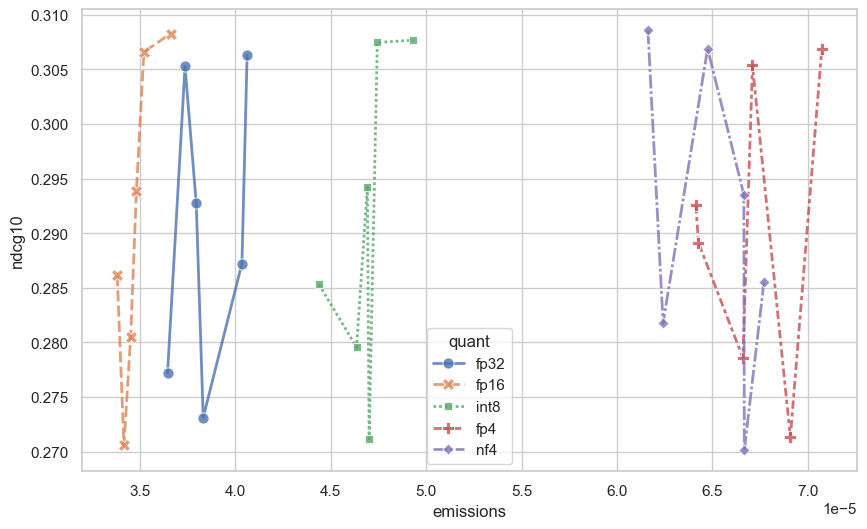

In [128]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# 1. Create the plot
# We use lineplot with markers to show the 'path' of pruning
# Assumes 'res' has a column 'pruning_level' (e.g., 0.1, 0.2...)
plot = sns.lineplot(
    data=res, 
    x="emissions", 
    y="ndcg10", 
    hue="quant", 
    style="quant", # Different line styles for accessibility
    markers=True, 
    markersize=8,
    alpha=0.8,
    linewidth=2
)

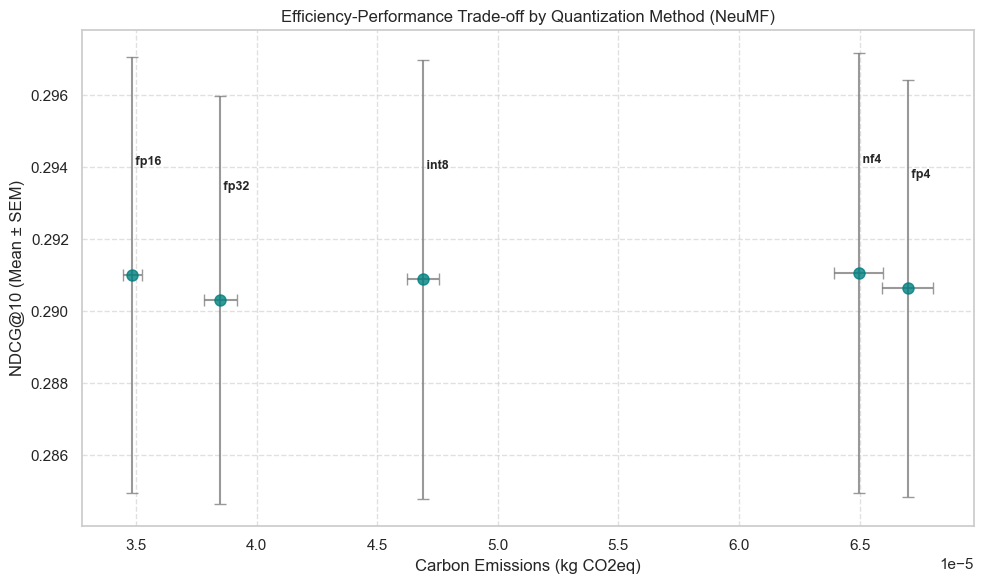

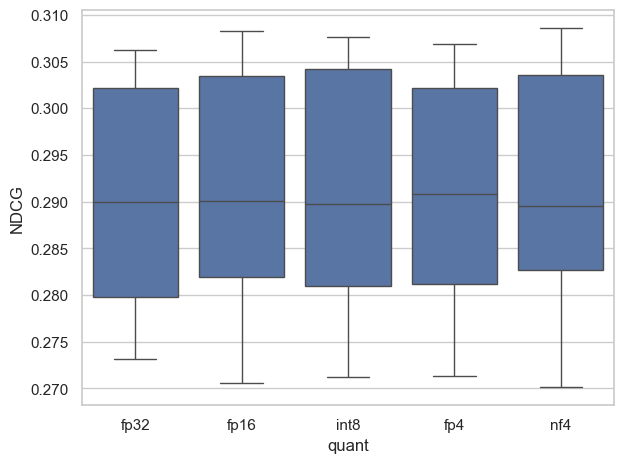

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Aggregate the data
agg = (
    res.groupby("quant")
       .agg(
           mean_emissions=("emissions", "mean"),
           std_emissions=("emissions", "std"),
           mean_ndcg=("ndcg10", "mean"),
           std_ndcg=("ndcg10", "std"),
           n=("ndcg10", "count"),
       )
       .reset_index()
)

# 2. Calculate Standard Error of the Mean (SEM)
agg["sem_emissions"] = agg["std_emissions"] / np.sqrt(agg["n"])
agg["sem_ndcg"] = agg["std_ndcg"] / np.sqrt(agg["n"])

# 3. Plotting
plt.figure(figsize=(10, 6))

# Added yerr for NDCG error bars
plt.errorbar(
    agg["mean_emissions"],
    agg["mean_ndcg"],
    xerr=agg["sem_emissions"],
    yerr=agg["sem_ndcg"],
    fmt="o",
    capsize=4,
    capthick=1,
    markersize=8,
    color="teal",
    ecolor="gray",
    alpha=0.8,
    label="Quantization Method"
)

# 4. Better Labeling
# We add a small offset to the text so it doesn't sit on the point
for _, r in agg.iterrows():
    plt.text(
        r["mean_emissions"], 
        r["mean_ndcg"] + (agg["sem_ndcg"].mean() * 0.5), # Vertical offset
        f' {r["quant"]}', 
        fontsize=9,
        fontweight='bold',
        va='bottom'
    )

plt.xlabel("Carbon Emissions (kg CO2eq)")
plt.ylabel("NDCG@10 (Mean ± SEM)")
plt.title("Efficiency-Performance Trade-off by Quantization Method (NeuMF)")
plt.grid(True, linestyle='--', alpha=0.6)

# Use scientific notation for X-axis if emissions are very small
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.show()
import seaborn as sns

sns.boxplot(data=res, x="quant", y="ndcg10")
plt.ylabel("NDCG")
plt.tight_layout()
plt.show()


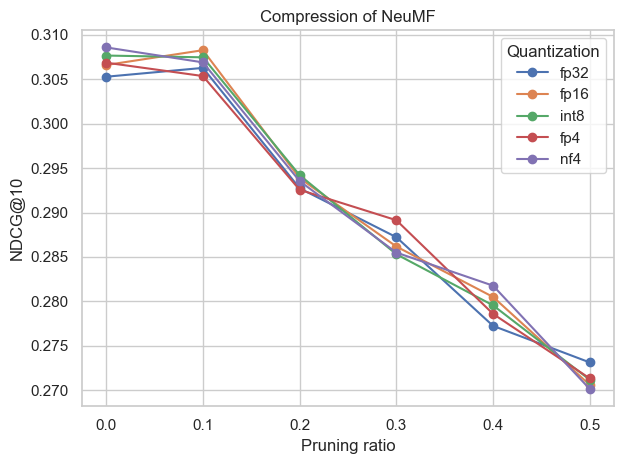

In [148]:
plt.figure()
for q in res["quant"].unique():
    sub = res[res["quant"] == q].sort_values("pruning")
    plt.plot(sub["pruning"], sub["ndcg10"], marker="o", label=q)

plt.title("Compression of NeuMF")
plt.xlabel("Pruning ratio")
plt.ylabel("NDCG@10")
plt.legend(title="Quantization")
plt.tight_layout()
plt.show()


C:\Users\Viktor Szolga\AppData\Local\Temp\ipykernel_12732\1800536140.py:9: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Viktor Szolga\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


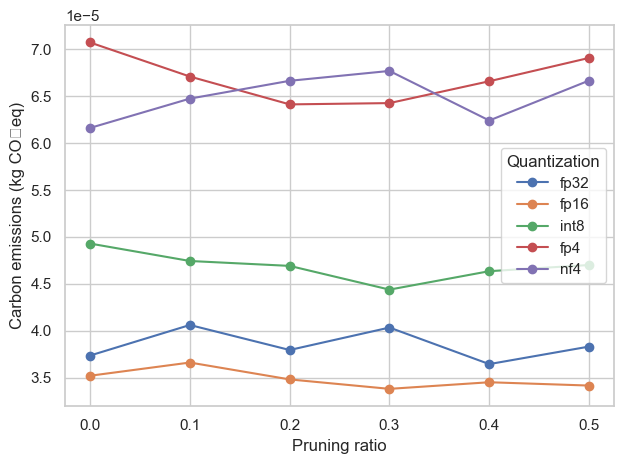

In [131]:
plt.figure()
for q in res["quant"].unique():
    sub = res[res["quant"] == q].sort_values("pruning")
    plt.plot(sub["pruning"], sub["emissions"], marker="o", label=q)

plt.xlabel("Pruning ratio")
plt.ylabel("Carbon emissions (kg CO₂eq)")
plt.legend(title="Quantization")
plt.tight_layout()
plt.show()


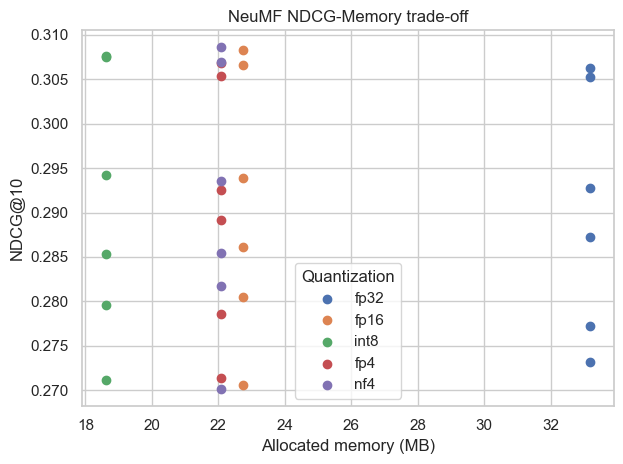

In [132]:
plt.figure()
for q in res["quant"].unique():
    sub = res[res["quant"] == q]
    plt.scatter(sub["allocated"], sub["ndcg10"], label=q)

plt.title("NeuMF NDCG-Memory trade-off")
plt.xlabel("Allocated memory (MB)")
plt.ylabel("NDCG@10")
plt.legend(title="Quantization")
plt.tight_layout()
plt.show()


In [133]:

em = pd.read_csv("emissions/nmf/emissions.csv")  # or bert/emissions.csv

em[["quant", "pruning"]] = em["experiment_id"].apply(parse_project)

C:\Users\Viktor Szolga\AppData\Local\Temp\ipykernel_12732\2791182172.py:23: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Viktor Szolga\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


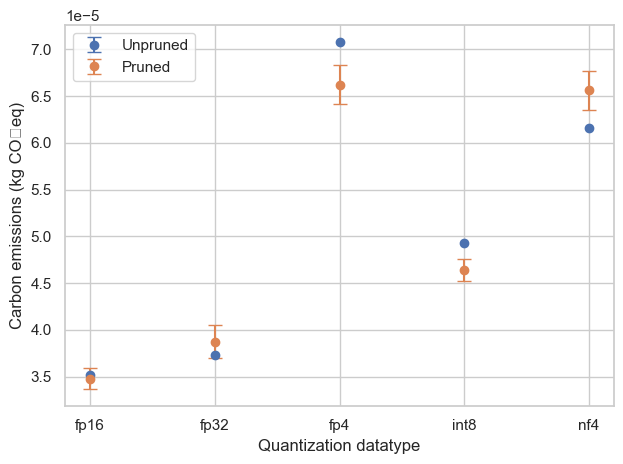

In [134]:
agg2 = (
    em.assign(pruned=em["pruning"] > 0)
      .groupby(["quant", "pruned"])["emissions"]
      .agg(["mean", "std"])
      .reset_index()
)
plt.figure()

for pruned, label in [(False, "Unpruned"), (True, "Pruned")]:
    sub = agg2[agg2["pruned"] == pruned]
    plt.errorbar(
        sub["quant"],
        sub["mean"],
        yerr=sub["std"],
        fmt="o",
        capsize=5,
        label=label
    )

plt.xlabel("Quantization datatype")
plt.ylabel("Carbon emissions (kg CO₂eq)")
plt.legend()
plt.tight_layout()
plt.show()


In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load results and emissions data
res = pd.read_csv("results/nmf.csv")
res[['quant','pruning']] = res['run_name'].apply(parse_method)  # yields quant and pruning columns
em = pd.read_csv("emissions/nmf/emissions.csv")
em[['quant','pruning']] = em['experiment_id'].apply(parse_project)

# Merge for combined plots if needed
merged = pd.merge(res, em[['experiment_id','duration']], left_on='run_name', 
                  right_on='experiment_id', how='left')


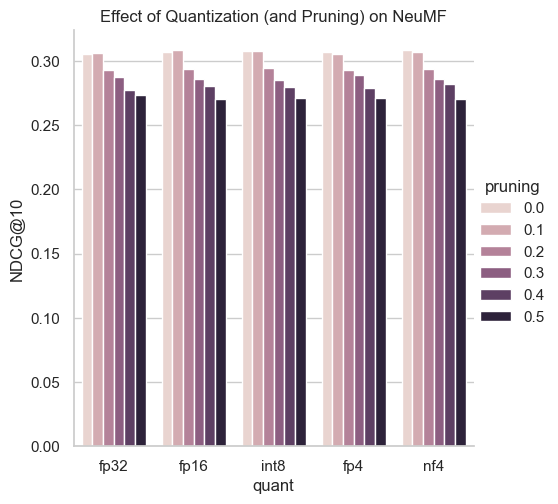

In [136]:
sns.catplot(x='quant', y='ndcg10', hue='pruning', kind='bar', data=res, errorbar='sd')
plt.ylabel("NDCG@10")
plt.title("Effect of Quantization (and Pruning) on NeuMF")
plt.show()

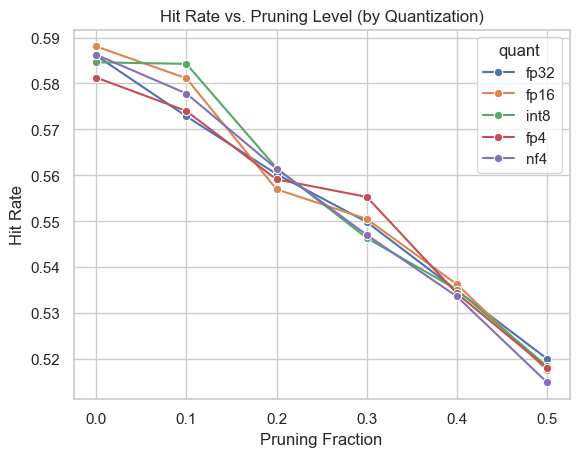

In [137]:
sns.lineplot(x='pruning', y='hr10', hue='quant', marker='o', data=res)
plt.xlabel("Pruning Fraction")
plt.ylabel("Hit Rate")
plt.title("Hit Rate vs. Pruning Level (by Quantization)")
plt.show()

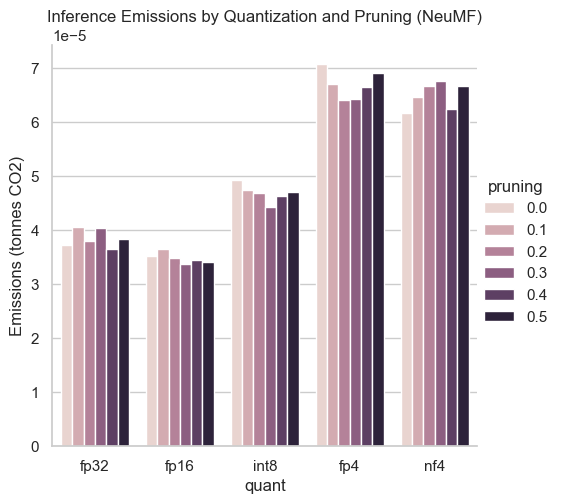

In [138]:
sns.catplot(x='quant', y='emissions', hue='pruning', kind='bar', data=res, errorbar='sd')
plt.ylabel("Emissions (tonnes CO2)")
plt.title("Inference Emissions by Quantization and Pruning (NeuMF)")
plt.show()

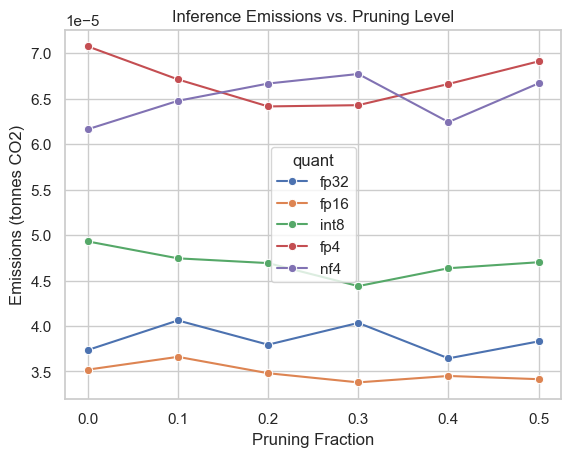

In [139]:
sns.lineplot(x='pruning', y='emissions', hue='quant', marker='o', data=res)
plt.xlabel("Pruning Fraction")
plt.ylabel("Emissions (tonnes CO2)")
plt.title("Inference Emissions vs. Pruning Level")
plt.show()

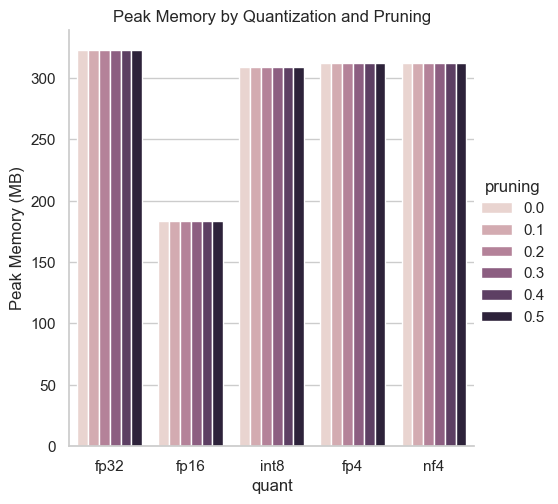

In [140]:
sns.catplot(x='quant', y='peak', hue='pruning', kind='bar', data=res, errorbar='sd')
plt.ylabel("Peak Memory (MB)")
plt.title("Peak Memory by Quantization and Pruning")
plt.show()

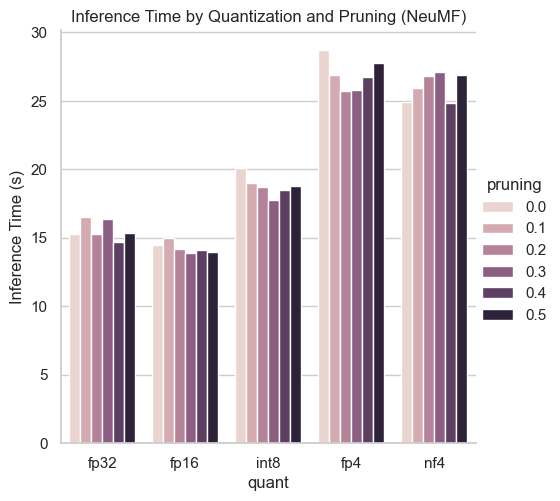

In [141]:
sns.catplot(x='quant', y='duration', hue='pruning', kind='bar', data=merged, errorbar='sd')
plt.ylabel("Inference Time (s)")
plt.title("Inference Time by Quantization and Pruning (NeuMF)")
plt.show()

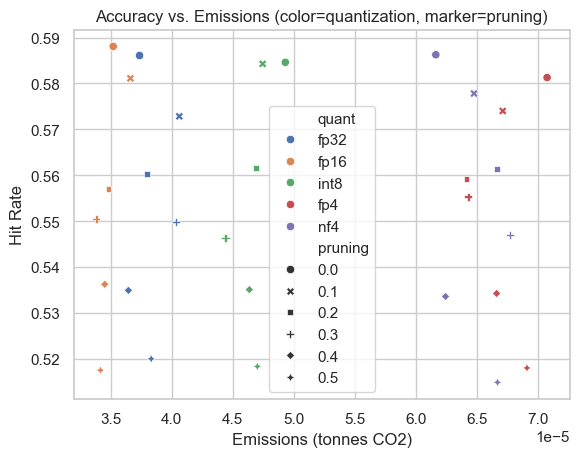

In [142]:
plt.figure()
sns.scatterplot(x='emissions', y='hr10', hue='quant', style='pruning', data=res)
plt.xlabel("Emissions (tonnes CO2)")
plt.ylabel("Hit Rate")
plt.title("Accuracy vs. Emissions (color=quantization, marker=pruning)")
plt.show()

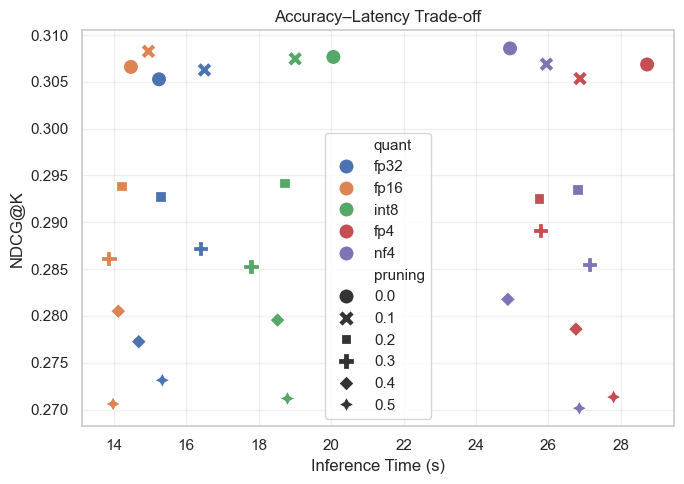

In [143]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=merged,
    x="duration",
    y="ndcg10",
    hue="quant",
    style="pruning",
    s=120
)
plt.xlabel("Inference Time (s)")
plt.ylabel("NDCG@K")
plt.title("Accuracy–Latency Trade-off")
plt.grid(True, alpha=0.3)
plt.tight_layout()


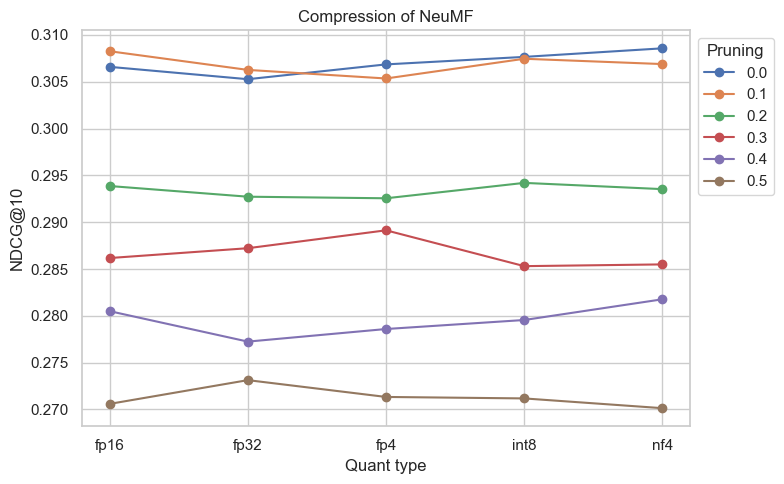

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5)) # Slightly wider to accommodate the legend
for q in res["pruning"].unique():
    sub = res[res["pruning"] == q].sort_values("quant") # Sorted by x-axis for clean lines
    plt.plot(sub["quant"], sub["ndcg10"], marker="o", label=q)

plt.title("Compression of NeuMF")
plt.xlabel("Quant type")
plt.ylabel("NDCG@10")

# Move legend outside to the right
plt.legend(title="Pruning", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()